# ➕ Evaluation handling

Serket uses dispatching over layers to determine the evaluation counterpart of a layer.For instance, during evaluation, the `Dropout` layer is replaced by an `Identity` layer, and the `BatchNorm` layer is replaced by an `EvalBatchNorm` layer. This ensures that when evaluating a tree of layers, users can follow the **"What you see is what you get" (WYSIWYG)** principle, meaning that Seeing a `Dropout`/`BatchNorm` in the model have one meaning.

 The dispatch design choice allow user to define layers like `Dropout` and `BatchNorm` that have different behaviors during training and evaluation without having to threading a training/eval flag through the layers.

In [1]:
!pip install git+https://github.com/ASEM000/serket --quiet

## Imports

In [2]:
import serket as sk
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import functools as ft
import jax

## Example: `Dropout`
The following example, train a sequential of layers with `Dropout` layer. then applies `tree_eval` to replace the `Dropout` with `Identity`

In [3]:
class Net(sk.TreeClass):
    def __init__(self, *, key: jax.Array):
        k1, k2 = jax.random.split(key)
        self.linear1 = sk.nn.Linear(1, 10, key=k1)
        self.dropout = sk.nn.Dropout(0.125)
        self.linear2 = sk.nn.Linear(10, 1, key=k2)

    def __call__(self, input: jax.Array, *, key: jax.Array):
        input = self.linear1(input)
        input = self.dropout(input, key=key)
        input = jnp.tanh(input)
        input = self.linear2(input)
        return input


net = sk.tree_mask(Net(key=jr.PRNGKey(0)))
x = jnp.linspace(-1, 1, 100)[..., None]
y = jnp.sin(x * 3.14)


@jax.jit
def train_step(net, x, y, key):
    keys = jax.random.split(key, len(x))

    def loss_func(net, x, y):
        net = sk.tree_unmask(net)
        ypred = jax.vmap(net)(x, key=keys)
        return jnp.mean((ypred - y) ** 2)

    grad = jax.grad(loss_func)(net, x, y)
    net = jax.tree_util.tree_map(lambda p, g: p - 1e-2 * g, net, grad)
    return net


key = jax.random.PRNGKey(0)

print("Before training", "-" * 80)
print(repr(net))
for i in range(10_000):
    key, subkey = jax.random.split(key)
    net = train_step(net, x, y, subkey)

net = sk.tree_unmask(net)

print("After training", "-" * 80)
print(repr(net))

Before training --------------------------------------------------------------------------------
Net(
  linear1=Linear(
    in_features=(#1), 
    out_features=(#10), 
    in_axis=(#-1), 
    out_axis=(#-1), 
    weight_init=#glorot_uniform, 
    bias_init=#zeros, 
    weight=f32[10,1](μ=-0.06, σ=0.42, ∈[-0.54,0.54]), 
    bias=f32[10](μ=0.00, σ=0.00, ∈[0.00,0.00])
  ), 
  dropout=Dropout(drop_rate=0.125, drop_axes=None), 
  linear2=Linear(
    in_features=(#10), 
    out_features=(#1), 
    in_axis=(#-1), 
    out_axis=(#-1), 
    weight_init=#glorot_uniform, 
    bias_init=#zeros, 
    weight=f32[1,10](μ=-0.03, σ=0.43, ∈[-0.70,0.60]), 
    bias=f32[1](μ=0.00, σ=0.00, ∈[0.00,0.00])
  )
)
After training --------------------------------------------------------------------------------
Net(
  linear1=Linear(
    in_features=(1), 
    out_features=(10), 
    in_axis=(-1), 
    out_axis=(-1), 
    weight_init=glorot_uniform, 
    bias_init=zeros, 
    weight=f32[10,1](μ=-0.20, σ=1.25, ∈[-2.

Apply `tree_eval`

Note how `Dropout` is replaced by `Identity`. No need to **thread** a train/eval flag!

In [4]:
print("Dropout before eval", "-" * 80)
print(repr(net.dropout))
net = sk.tree_eval(net)
print("Dropout after eval", "-" * 80)
print(repr(net.dropout))

Dropout before eval --------------------------------------------------------------------------------
Dropout(drop_rate=f32[](μ=0.12, σ=0.00, ∈[0.12,0.12]), drop_axes=None)
Dropout after eval --------------------------------------------------------------------------------
Identity()


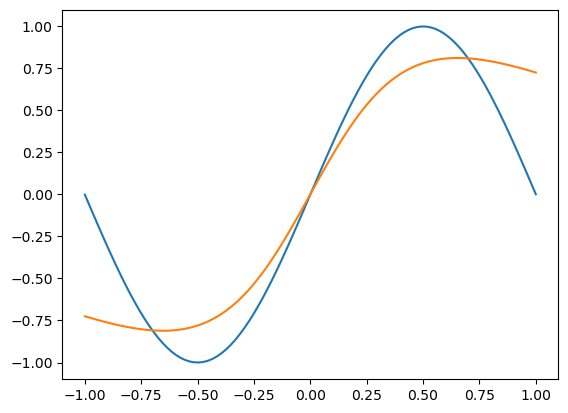

In [5]:
plt.plot(x, y, label="true")
plt.plot(x, jax.vmap(lambda input: net(input, key=None))(x), label="pred")

## Custom evaluation rule

The following shows how to define an evaluation behavior for a layer that exhibits different behavior based on eval/train status.

In [6]:
class AddOne(sk.TreeClass):
    def __call__(self, x: jax.Array) -> jax.Array:
        return x + 1


x = jax.numpy.ones([3, 3])

add_one = AddOne()


class AddOneEval(sk.TreeClass):
    def __call__(self, x: jax.Array) -> jax.Array:
        return x  # no-op


@sk.tree_eval.def_eval(AddOne)
def _(_: AddOne) -> AddOneEval:
    return AddOneEval()


print(add_one(x))
print(sk.tree_eval(add_one)(x))

[[2. 2. 2.]
 [2. 2. 2.]
 [2. 2. 2.]]
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
